В данном задании нам необходимо написать чат-бота, испльзуя модель seq2seq.

Ссылка на базу https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt

База содержит примеры пар: вопрос-ответ. По аналогии с моделью преводчика (англ - рус), нужно создать чат-бота (вопрос - ответ).

In [1]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

import re

In [2]:
# Загрузим обучающие тексты

!wget  https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt

--2022-02-07 07:49:43--  https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748135 (731K) [text/plain]
Saving to: ‘9kdialogs.txt’

9kdialogs.txt       100%[===================>] 730.60K  --.-KB/s    in 0.006s  

2022-02-07 07:49:43 (112 MB/s) - ‘9kdialogs.txt’ saved [748135/748135]



In [3]:
# Убедимся, что файл со текстами загружен
!ls

9kdialogs.txt  sample_data


In [5]:
# считываем данные
with open('9kdialogs.txt', 'r') as f:     # Открываем файл на чтение
  text = f.read()                                                               # Читаем весь файл

  # Отпарсим текст, убрав знаки препинания, знаки перевода строки
  text = text.replace('\ufeff', '') 
  text = re.sub(r'[^А-я-]', ' ', text)
text

'- - Как вы можете быть таким уверенным  - Элементарно   - - А что делать будем  - Ждать  - - Надеюсь  не до первой звезды  - Я тоже на это надеюсь   - - За что  - Вы знаете за что   - - Ты что-нибудь понимаешь  - Абсолютно ничего   - - Обсудим это завтра  ладно  - Хорошо   - - Кто услышит  - Кто-кто  Ну твой следователь   - - Что - если  - Так  ничего   - - Ну я пойду  - А  Иди  иди  Постой     - - Может  стоило ее предупредить  - Может   - - А вы тут  что ли  не одна живете  - Нет  я живу здесь не одна   - - В рублях или долларах  - В долларах  конечно   - - А теперь  значит  он уже столичная штучка  - Ну да  А что  ты его знаешь   - - Эй  А на курево тебя можно разорить  - Возьми в столе   - - Что  достали  - Да они кого угодно достанут   - - Ты что  издеваешься  - Ага  А как ты догадался   - - Чего тебе  - Я хотел бы поговорить с дамой   - - А вы  собственно  кто  - А я ее концертмейстер   - - И как мне ее найти  Где она сейчас работает  - Она не работает   - - Печальная история  Е

In [7]:
parts = text.rsplit('- - ')   # сделаем наш текст итерируемым, каждый объект - строка - вопрос-ответ

In [8]:
# посмотрим на то, что получилось в настоящий момент
for i in parts[0:10]:
  print(i)


Как вы можете быть таким уверенным  - Элементарно   
А что делать будем  - Ждать  
Надеюсь  не до первой звезды  - Я тоже на это надеюсь   
За что  - Вы знаете за что   
Ты что-нибудь понимаешь  - Абсолютно ничего   
Обсудим это завтра  ладно  - Хорошо   
Кто услышит  - Кто-кто  Ну твой следователь   
Что - если  - Так  ничего   
Ну я пойду  - А  Иди  иди  Постой     


In [9]:
parts=parts[1:]

In [10]:
len(parts)

8926

In [11]:
count_tire=[]
for par in parts:
  if not " - " in par:
    count_tire.append(par)
count_tire

['Бери круче     ',
 'Не зацепило  -Нет   ',
 'Здесь все   ',
 'Сегодня  Никого    ',
 'Ничего не сорвалось  Ничего не сорвалось   ',
 'Я учту   ',
 'А вы не погорячились   ',
 'Я страшно хочу есть     ',
 'Слушаю тебя   ',
 'Потому что ты   ',
 'Хорошо   ',
 'Хорошо   ',
 'Идем   ',
 'А когда вы были там последний раз   ',
 'Мои соболезнования   ',
 'Не бойтесь   ',
 'Даня  прекрати пожалуйста   ',
 'Разве я давала повод   ',
 'Что ты   Девственница      ',
 'Сегодня хороший день   ',
 'У меня аллергия на собак   ',
 'Вы   ',
 'Да нет же  Просто     ',
 'И кого она принимала   ',
 'Хорошо  жду сообщений   ',
 'Немедленно   ',
 'Нужна машина  яд выдыхается   ',
 'Хорошо   ',
 'Как скажешь   ',
 'Ничего страшного   ',
 'Что там произошло  Я слышала выстрелы  ',
 'Потом  потом  На нас снова напали   ',
 'Интересно   ',
 'Это действительно интересно   ',
 'Обещаешь   ',
 'Покиньте купе   ',
 'Это было на прошлой неделе   ',
 'Я не за делом  я в гости   ',
 'Пожар  что ли  Ладно  сейчас   

In [12]:
# Собираем вопросы и ответы в списки

questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз

for con in parts:    
  if " - " in con:
    questions.append(con.split(' - ')[0])
    answers.append(con.split(' - ')[1])
  else:
    pass

In [13]:
for q in questions[:5]:
  print(q)
print(len(questions))

Как вы можете быть таким уверенным 
А что делать будем 
Надеюсь  не до первой звезды 
За что 
Ты что-нибудь понимаешь 
8751


In [14]:
for a in answers[:5]:
  print(a)
print(len(answers))

Элементарно   
Ждать  
Я тоже на это надеюсь   
Вы знаете за что   
Абсолютно ничего   
8751


In [15]:
# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[112])) # Пример входной фразы
print('Ответ : {}'.format(answers[112]))    # Пример ответной фразы

Вопрос : Согласен  Подумай 
Ответ : <START> Согласен    <END>


Мы предобработали базу данных, собрали два списка: с вопросами и ответами, длины их совпадают, добавили теги в ответную фразу, можно создавать токенайзер

In [16]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))           

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('ты', 5), ('а', 6), ('я', 7), ('в', 8), ('да', 9), ('это', 10), ('вы', 11), ('как', 12), ('нет', 13), ('и', 14), ('где', 15), ('ну', 16), ('на', 17), ('у', 18), ('с', 19), ('кто', 20), ('так', 21), ('же', 22), ('он', 23), ('то', 24), ('все', 25), ('мне', 26), ('чего', 27), ('куда', 28), ('там', 29), ('есть', 30), ('за', 31), ('тебя', 32), ('тебе', 33), ('вас', 34), ('меня', 35), ('еще', 36), ('вам', 37), ('знаю', 38), ('мы', 39), ('ничего', 40), ('здесь', 41), ('почему', 42), ('она', 43), ('может', 44), ('можно', 45), ('конечно', 46), ('чем', 47), ('зачем', 48), ('его', 49), ('сейчас', 50)]
Размер словаря : 10198


In [17]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[100]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))       

Пример входной фразы                         : А вообще ты сегодня занят 
Пример кодированной входной фразу            : [   6  219    5  105 2168    0    0    0    0    0    0]
Размеры закодированного массива входных фраз : (8751, 11)
Установленная длина входных фраз             : 11


In [18]:
# Те же манипуляции с выходными данными для обучения:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))        

Пример оригинального ответа на вход: <START> Да  вроде  ничего особенного    <END>
Пример кодированного ответа на вход : [  1   9 168  40 424   2   0   0   0   0   0   0   0   0]
Размеры кодированного массива ответов на вход : (8751, 14)
Установленная длина ответов на вход : 14


In [19]:
#Те же манипуляции с выходными данными для проверки. Убирает тег < start >.

#Сетка не будет выдавать фразы с этим тэгом, поэтому и контрольные фразы должны быть без него:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
    tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)       

In [20]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers))

Пример кодированного ответа на вход : [  1   9 168  40 424   2   0   0   0   0   0   0   0   0]
Пример кодированного ответа на выход : [  9 168  40 424   2   0   0   0   0   0   0   0   0   0]
Размеры кодированного массива ответов на выход : (8751, 14)
Установленная длина вопросов на выход : 14


In [21]:
#Создадим энкодер. Он состоит из входного слоя, Embedding-а и одной LSTM.
#На его вход будет подавать предложение, на которое нужно ответить. На выходе - векторы состояния. Они являются исходной информацией для декодера.
encoderInputs = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)  # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding) # Добавим LSTM
encoderStates = [state_h, state_c]                                                 # Соберем выходы lstm  в список    

In [22]:
#Вторая часть нейронки - это декодер. Он также содержит входной слой, Embedding и одну LSTM.
#На входе обучающая фраза, на выходе предсказанное слово - в виде длинного-длинного массива One-Hot-Encoding (OHE).
#Массив выглядит '0,0,0,0,1,0,0,0,0,0,0', где позиция единички указывает на индекс слова, присвоенный токенайзером

# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

In [23]:
#Пора собирать кодер и декодер вместе.
#Посмотрим на структуру построенный сети. Заметим, что при обучении будем минимизировать sparse_categorical_crossentropy.
# Собираем модель
model = Model([encoderInputs, decoderInputs], output)

In [24]:
# Компилиуем модель

model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

In [25]:
# Выведем на экран информацию о построенной модели нейросети

print(model.summary())  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    2039600     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    2039600     ['input_2[0][0]']                
                                                                                              

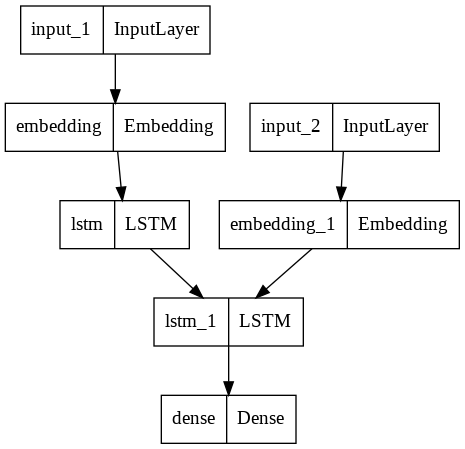

In [26]:
# Построим график для визуализации слоев и связей между ними

plot_model(model, to_file='model.png')

In [27]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=30) 
# Сохраним модель на диске
model.save( 'content/model_30epochs(rms).h5' )

Epoch 1/30
35/35 [==============================] - 69s 2s/step - loss: 2.2037
Epoch 2/30
35/35 [==============================] - 57s 2s/step - loss: 1.7647
Epoch 3/30
35/35 [==============================] - 58s 2s/step - loss: 1.6403
Epoch 4/30
35/35 [==============================] - 58s 2s/step - loss: 1.5773
Epoch 5/30
35/35 [==============================] - 58s 2s/step - loss: 1.5411
Epoch 6/30
35/35 [==============================] - 58s 2s/step - loss: 1.5126
Epoch 7/30
35/35 [==============================] - 57s 2s/step - loss: 1.4858
Epoch 8/30
35/35 [==============================] - 67s 2s/step - loss: 1.4602
Epoch 9/30
35/35 [==============================] - 57s 2s/step - loss: 1.4356
Epoch 10/30
35/35 [==============================] - 58s 2s/step - loss: 1.4126
Epoch 11/30
35/35 [==============================] - 57s 2s/step - loss: 1.3922
Epoch 12/30
35/35 [==============================] - 57s 2s/step - loss: 1.3698
Epoch 13/30
35/35 [==============================

In [28]:
# Сохраним веса модели
model.save_weights('s2s_30epochs.h5')

In [34]:
def makeInferenceModels():

    ''' Функция сборки сети для перевода фраз из уже обученных слоев

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel = Model(encoderInputs, encoderStates) 

    # Создадим модель декодера
    decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
    decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

    # Соберем оба inputs вместе и запишем в decoderStatesInputs
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) 
    
    # LSTM даст нам новые состояния
    decoderStates = [state_h, state_c]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs = decoderDense(decoderOutputs) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel , decoderModel

Сервисная функция для перевода произвольной фразы в токены. Функция разбирает фразу на слова. Для каждого слова находит свой индекс. Его подскажет токенайзер. И дополняет полученный список индексов нулями до максимальной длины. Используется для подготовки фразы к ее переводу. Принимает на вход строку, отдает список токенов

In [30]:
def strToTokens(sentence: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

In [31]:
import numpy as np
emptyTargetSeq = np.zeros((1, 1))


emptyTargetSeq[0, 0] = 5

emptyTargetSeq

array([[5.]])

In [32]:
encModel , decModel = makeInferenceModels() 

Начинаем работу нашего чат-бота. Нейронка попросит на вход 6 (лучше простеньких) фраз и выдаст то, что она об этом думает. Работаем в цикле.

Начнем с подготовки:

Сначала запросим фразу у пользователя, переведем ее в токены при помощи функции strToTokens() и поместим результат в переменную qua.
Проверим, не состоит ли фраза из полностью незнакомых слов.
Создадим массив emptyTargetSeq вида [[0.]], поместим в его начало слово start в виде индекса.
Определим условие остановки генерации stopCondition
Создадим переменную decodedTranslation для сборки ответа
Прогоним фразу через энкодер и поместим результат в переменную statesValues
Далее, пока не сработало стоп-условие, в модель декодера подаем пустую последовательность со словом 'start' и состояния, предсказанные кодером по заданному вопросу. Декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния. Поместим результат в переменные decOutputs , h , c.

Обработаем предсказанное слово функцией np.argmax, получим его индекс и поместим резуьтат в переменную sampledWordIndex.

Создадим переменную sampledWord для слов, преобразованных в естественный язык.

Переберем в цикле все индексы токенайзера, и если индекс выбранного слова соответствует какому-то индексу из словаря, то слово, идущее под этим индексом в словаре, добавляется в итоговый ответ. Плюс выбранное слово фиксируем в переменную sampledWord. Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа - срабатывает стоп-условие и прекращаем генерацию.

Создаем пустой массив, заносим в него индекс выбранного слова. Сохраняем в список statesValues состояния, обновленные декодером.

Выводим ответ сгенерированный декодером.

In [36]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания

        Args: строка или список строк

        Returns: строка или список строк
    '''

    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

In [38]:
# Цикл по количеству входных фраз - их 6

for _ in range(6):

    # подготовка
    
    qua  = strToTokens(input('Исходная фраза - вопрос боту: '))
    if qua is None:                                      
        print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        continue                                             # Пойдем за следущей фразой

    emptyTargetSeq = np.zeros((1, 1))                    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
    stopCondition = False                                
    decodedTranslation = '' 
    statesValues = encModel.predict(qua)                              

    # пока не сработало стоп-условие
    while not stopCondition:                             

        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
        # Получим индекс предсказанного слова.
        sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():
        
            # Если индекс выбранного слова соответствует какому-то индексу из словаря
            if sampledWordIndex == index:              
                # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
                decodedTranslation += ' {}'.format(word) 
                # Выбранное слово фиксируем в переменную sampledWord
                sampledWord = word                       
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
        if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
            stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
        emptyTargetSeq = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
        emptyTargetSeq[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
        statesValues = [h, c]   

        # И продолжаем цикл с обновленными параметрами                
                                                
    # Выводим ответ сгенерированный декодером
    print("Ответ Чат-Бота: ", decodedTranslation) 

Исходная фраза - вопрос боту: как настроение
Ответ Чат-Бота:   это не знаю end
Исходная фраза - вопрос боту: а кто знает
Ответ Чат-Бота:   я не знаю end
Исходная фраза - вопрос боту: ну а кто-то хоть знает
Ответ Чат-Бота:   ага end
Исходная фраза - вопрос боту: бог?
а вот спросите меня о чем-нить полезном: 
Исходная фраза - вопрос боту: ты не знаешь слово Бог?
Ответ Чат-Бота:   нет end
Исходная фраза - вопрос боту: а производные умеешь рассчитывать
Ответ Чат-Бота:   ну что end


Ну что, Чат-бот получился - просто огонь, хоть и не умеет рассчитывать производные ))). Данное исследование достигло своей цели. Чат-бот обучен при помощи модели Sequence-to-sequence, на вопросы отвечает очень даже прилично.